less is more - kaggle santander

# start

from 0319_1 add date time features

In [3]:
PRFX='0319_4'
trntmstmp=1584412344
valtmstmp=1584626395
import datetime
[datetime.datetime.fromtimestamp(o).strftime('%Y-%m-%d %H:%M:%S') for o in (trntmstmp, valtmstmp)]

['2020-03-17 02:32:24', '2020-03-19 13:59:55']

# setup

In [4]:
from pathlib import Path
import dask
print('dask.__version__', dask.__version__)
import xgboost as xgb
import dask_xgboost
import dask.dataframe as dd
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from dask.distributed import Client
import pickle
import lightgbm as lgb
from tqdm import tqdm

import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

SEED=101
HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

cols=[
'toks',
'hshtgs',
'twtid',
'media',
'links',
'domns',
'twttyp',
'lang',
'tm',

'u1id',
'u1_fllwer_cnt',
'u1_fllwing_cnt',
'u1_vrfed',
'u1_create_tm',

'u2id',
'u2_follower_cnt',
'u2_following_cnt',
'u2_vrfed',
'u2_create_tm',

'u1_fllw_u2',
'reply_tm',
'retwt_tm',
'retwt_cmmnt_tm',
'like_tm',
]

cols_val = cols[:-4]
cols_tgt_tmstmp=[
    'retwt_tm',
    'reply_tm',
    'like_tm',
    'retwt_cmmnt_tm',
]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
ntgts=len(tgts)

dask.__version__ 2.12.0


# prepare data

## get maps from dfval

In [5]:
# dfval=dd.read_csv(
#     f'{p_in}/val_{valtmstmp}.tsv',
#     sep='\x01', header=None, names=cols_val,)
# lang2cnt=dict(dfval.lang.value_counts().compute())
# ttl=sum(lang2cnt.values())
# lang2perc={k:v/ttl for k,v in lang2cnt.items()}
langs=['D3164C7FBCF2565DDF915B1B3AEFB1DC', '22C448FF81263D4BAF2A176145EE9EAD', '06D61DCBBE938971E1EA0C38BD9B5446', 'ECED8A16BE2A5E8871FD55F4842F16B1', 'B9175601E87101A984A50F8A62A1C374', '4DC22C3F31C5C43721E6B5815A595ED6', '167115458A0DBDFF7E9C0C53A83BAC9B', '125C57F4FA6D4E110983FB11B52EFD4E', '022EC308651FACB02794A8147AEE1B78', 'FA3F382BC409C271E3D6EAF8BE4648DD', '9BF3403E0EB7EA8A256DA9019C0B0716', '975B38F44D65EE42A547283787FF5A21', '2996EB2FE8162C076D070A4C8D6532CD', 'FF60A88F53E63000266F8B9149E35AD9', '717293301FE296B0B61950D041485825', '3E16B11B7ADE3A22DDFC4423FBCEAD5D', '3820C29CBCA409A33BADF68852057C4A', '9ECD42BC079C20F156F53CB3B99E600E', '76B8A9C3013AE6414A3E6012413CDC3B', 'AEF22666801F0A5846D853B9CEB2E327', '190BA7DA361BC06BC1D7E824C378064D', '1FFD2FE4297F5E70EBC6C3230D95CB9C', 'A0C7021AD8299ADF0C9EBE326C115F6F', 'D413F5FE5236E5650A46FD983AB39212', '48236EC80FDDDFADE99420ABC9210DDF', '691890251F2B9FF922BE6D3699ABEFD2', '920502FAA080485768AA89BC96A55C47', '0331BF70E606D62D92C96CE9AD71A7CF', '89616CFF8EC8637092F885C7EFF43D74', '06BEAB41D66CCFF329D1ED8BA120A6C2', '60FBA0E834CC59D647C3599AD763FFDF', 'C7A400D9AD489ACF673CF12FBB80AAE5', 'E59EF8BB86A6D815331DDF4C467CE0C7', '4249CE88433AEA3F8DCEECF008B3CB95', '544FA32458C903F1125FE6598300A047', 'CB11E9CF42BD0A1BAD5E27BF3422D99D', '3A85BCEC571C3F5AB1069E4924189177', 'FF7EABB5A382356D54D9C41BA0125E09', 'E7BB61D2A87C1E72DF1C7BC292B86A1C', '69C4A33B9AD29AF883D60BA61CC08702', 'F4FD40A716F1572C9A28E9CAA58BE3A5', '259A6F6DFD672CB1F883CBEC01B99F2D', '6431A618DCF7F4CB7F62A95A39BAB77A', '3121F7240D488F74EEED9312E174B217', '54208B51D44E7D91DC2F3DD02ADEDEC2', 'DBEEFB80F8A314311E2B4BD593E11DFE', 'B6D90127A09AB1229731898AEF9D4D7C', 'F3E1016563360F9434FA986CA86C249C', '2216D01F7B48554E4211021A46816FCF', '1BC639981AE88E09129594B11F894A21', 'C942E369C88CE7C56E69A84D04319FF0', '57ADD4576E2AD6648E9B2DE32F3462A5', 'AC1F0671A4B0D5B8112F87DE7B490E6D', 'C2EF5FABE7619D8A333D5F0FF76E1BFA', 'AA0254541959271ED3453119B787D0C3', 'A6B70CDF8C7B934D4A218CA9B6B7FDB4', 'BF477808A37E3E4E9C5D9F1839E8519E', '97F81BD92A1ACA3F1F43C154E689350F', '60A3DB168094D41241E45E0DE3539BC0', '12D8CEB94F89D11D7EB95EAE9689B009', 'F73266A79468BB89C4325FDEDB0B533C', '4690215948DBF6872B8ED1C2BC87B17E', 'D18801336202297E6484F634CAC6592E', '2E18F6F53E3CF073911AF0A93BBE5373', 'B2235C8B73239FDC5780DD132419833A', '515E873C86EE1577E75FA2387B7FA59E',]

# dfval.twttyp.value_counts().compute()
# TopLevel    2932
# Retweet      994
# Quote        213
twttyps=['TopLevel','Retweet','Quote']

In [6]:
def prp_df(df):
    df['len_toks']=df.toks.apply(len)
    for media in ['Photo', 'Video', 'GIF']:
        df[f'has_media_{media}'] = df.media.fillna('').apply(lambda x: media in x)
    for col in ['hshtgs', 'links', 'domns',]:
        df[f'num_{col}'] = df[col].fillna('').apply(lambda x: len(x.split('\t')) if len(x) else 0)
    tm_dt=pd.to_datetime(df.tm, unit='s')
    df['tm_month']=tm_dt.dt.month
    df['tm_dayofweek']=tm_dt.dt.dayofweek
    df['tm_day']=tm_dt.dt.day
    df['tm_hour']=tm_dt.dt.hour
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    df['tmdlta_twtu1'] = df.tm - df.u1_create_tm
    df['tmdlta_twtu2'] = df.tm - df.u2_create_tm

    for typ in twttyps:
        df[f'twttyp_{typ}']=(df.twttyp==typ).astype('int8')

    for lang in langs:
        df[f'lang_{lang}']=(df.lang==lang).astype('int8')
    df.drop(inplace=True, columns=['toks', 'hshtgs', 'media', 'links', 'domns', 'twttyp', 'lang', 'u1id',], )
    return df

In [16]:
chnks_trn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',
                    header=None,names=cols, 
                        chunksize=1e5
                       )

np.random.seed(SEED)
lst_df = []
for ichnk,df in enumerate(chnks_trn):
    if np.random.rand()>0.1: continue

    print(dtnow(), 'chunk', ichnk)
    
    df = prp_df(df)    
    
    idx0    =np.where(df[cols_tgt_tmstmp].notna().sum(1)==0)[0]
    idx1    =np.where(df[cols_tgt_tmstmp].notna().sum(1)==1)[0]
    idx2    =np.where(df[cols_tgt_tmstmp].notna().sum(1)>1)[0]
        
    df0=df.iloc[idx0].copy()
    df0['tgt']=ntgts
    df1=df.iloc[idx1].copy()
    df1['tgt']=np.argmax(df1[cols_tgt_tmstmp].notna().values, 1)
    
    df2_=df.iloc[idx2]
    rows_new=[]
    for _, row in tqdm(df2_.iterrows(), total=len(df2_)):
        idx_tgt = np.where(row[cols_tgt_tmstmp].notna())[0]
        for i_tgt in idx_tgt:
            row_new = row.copy()
            row_new['tgt']=i_tgt
            rows_new.append(row_new)
    df2=pd.DataFrame(rows_new)
    
    df=pd.concat([df0,df1,df2])
    df.drop(inplace=True, columns=['reply_tm', 'retwt_tm', 'retwt_cmmnt_tm', 'like_tm',])

    lst_df.append(df)
    



2020-03-19 21:16:04 chunk 2


100%|██████████| 7098/7098 [00:26<00:00, 268.76it/s]


2020-03-19 21:16:52 chunk 16


100%|██████████| 7084/7084 [00:26<00:00, 269.32it/s]


2020-03-19 21:17:32 chunk 22


100%|██████████| 7101/7101 [00:26<00:00, 270.01it/s]


2020-03-19 21:18:29 chunk 40


100%|██████████| 7046/7046 [00:43<00:00, 160.45it/s]


2020-03-19 21:19:31 chunk 52


100%|██████████| 7086/7086 [00:26<00:00, 269.65it/s]


2020-03-19 21:20:28 chunk 58


100%|██████████| 7109/7109 [00:26<00:00, 269.63it/s]


2020-03-19 21:21:10 chunk 68


100%|██████████| 7190/7190 [00:26<00:00, 271.00it/s]


2020-03-19 21:21:54 chunk 79


100%|██████████| 7107/7107 [00:26<00:00, 269.11it/s]


2020-03-19 21:22:35 chunk 88


100%|██████████| 7061/7061 [00:26<00:00, 270.19it/s]


2020-03-19 21:23:08 chunk 90


100%|██████████| 7344/7344 [00:27<00:00, 271.34it/s]


2020-03-19 21:23:45 chunk 94


100%|██████████| 7048/7048 [00:25<00:00, 271.43it/s]


2020-03-19 21:25:14 chunk 134


100%|██████████| 7203/7203 [00:27<00:00, 264.60it/s]


2020-03-19 21:25:49 chunk 137


100%|██████████| 7158/7158 [00:26<00:00, 268.51it/s]


2020-03-19 21:26:38 chunk 152


100%|██████████| 6993/6993 [00:26<00:00, 266.16it/s]


2020-03-19 21:27:15 chunk 158


100%|██████████| 7211/7211 [00:26<00:00, 268.38it/s]


2020-03-19 21:28:06 chunk 174


100%|██████████| 7053/7053 [00:26<00:00, 266.02it/s]


2020-03-19 21:28:50 chunk 185


100%|██████████| 7025/7025 [00:26<00:00, 266.22it/s]


2020-03-19 21:29:38 chunk 198


100%|██████████| 7189/7189 [00:27<00:00, 266.06it/s]


2020-03-19 21:30:16 chunk 203


100%|██████████| 7013/7013 [00:26<00:00, 263.24it/s]


2020-03-19 21:31:00 chunk 214


100%|██████████| 7113/7113 [00:26<00:00, 265.85it/s]


2020-03-19 21:31:41 chunk 223


100%|██████████| 7233/7233 [00:28<00:00, 253.81it/s]


2020-03-19 21:32:46 chunk 250


100%|██████████| 7249/7249 [00:27<00:00, 267.65it/s]


2020-03-19 21:33:22 chunk 254


100%|██████████| 7356/7356 [00:27<00:00, 263.47it/s]


2020-03-19 21:34:11 chunk 268


100%|██████████| 7215/7215 [00:27<00:00, 266.58it/s]


2020-03-19 21:34:52 chunk 276


100%|██████████| 7223/7223 [00:27<00:00, 265.98it/s]


2020-03-19 21:35:26 chunk 278


100%|██████████| 7192/7192 [00:26<00:00, 268.35it/s]


2020-03-19 21:36:03 chunk 283


100%|██████████| 7275/7275 [00:27<00:00, 264.21it/s]


2020-03-19 21:36:37 chunk 284


100%|██████████| 7068/7068 [00:26<00:00, 262.53it/s]


2020-03-19 21:38:34 chunk 356


100%|██████████| 7139/7139 [00:27<00:00, 258.43it/s]


2020-03-19 21:39:07 chunk 357


100%|██████████| 7139/7139 [00:27<00:00, 263.92it/s]


2020-03-19 21:39:47 chunk 363


100%|██████████| 7041/7041 [00:26<00:00, 269.23it/s]


2020-03-19 21:40:22 chunk 367


100%|██████████| 7328/7328 [00:27<00:00, 268.70it/s]


2020-03-19 21:41:01 chunk 373


100%|██████████| 7234/7234 [00:27<00:00, 266.54it/s]


2020-03-19 21:41:39 chunk 379


100%|██████████| 7108/7108 [00:26<00:00, 268.58it/s]


2020-03-19 21:42:13 chunk 381


100%|██████████| 7269/7269 [00:29<00:00, 249.39it/s]


2020-03-19 21:42:52 chunk 385


100%|██████████| 7040/7040 [00:26<00:00, 265.81it/s]


2020-03-19 21:43:29 chunk 390


100%|██████████| 7467/7467 [00:28<00:00, 266.61it/s]


2020-03-19 21:44:16 chunk 402


100%|██████████| 6935/6935 [00:26<00:00, 266.70it/s]


2020-03-19 21:44:53 chunk 408


100%|██████████| 6971/6971 [00:26<00:00, 266.53it/s]


2020-03-19 21:45:28 chunk 412


100%|██████████| 7208/7208 [00:27<00:00, 264.84it/s]


2020-03-19 21:46:08 chunk 419


100%|██████████| 7080/7080 [00:26<00:00, 266.34it/s]


2020-03-19 21:46:41 chunk 421


100%|██████████| 7161/7161 [00:26<00:00, 267.42it/s]


2020-03-19 21:47:21 chunk 429


100%|██████████| 7123/7123 [00:26<00:00, 267.76it/s]


2020-03-19 21:47:56 chunk 431


100%|██████████| 7190/7190 [00:27<00:00, 259.64it/s]


2020-03-19 21:48:44 chunk 443


100%|██████████| 7236/7236 [00:27<00:00, 267.92it/s]


2020-03-19 21:49:29 chunk 454


100%|██████████| 7286/7286 [00:27<00:00, 267.88it/s]


2020-03-19 21:50:02 chunk 455


100%|██████████| 7122/7122 [00:26<00:00, 267.03it/s]


2020-03-19 21:50:40 chunk 461


100%|██████████| 7152/7152 [00:26<00:00, 266.53it/s]


2020-03-19 21:51:18 chunk 466


100%|██████████| 7168/7168 [00:27<00:00, 261.83it/s]


2020-03-19 21:52:01 chunk 476


100%|██████████| 7148/7148 [00:26<00:00, 268.90it/s]


2020-03-19 21:52:44 chunk 486


100%|██████████| 7052/7052 [00:26<00:00, 268.35it/s]


2020-03-19 21:53:20 chunk 491


100%|██████████| 7243/7243 [00:27<00:00, 267.51it/s]


2020-03-19 21:53:56 chunk 495


100%|██████████| 7035/7035 [00:26<00:00, 261.41it/s]


2020-03-19 21:54:32 chunk 499


100%|██████████| 7120/7120 [00:26<00:00, 267.40it/s]


2020-03-19 21:55:10 chunk 506


100%|██████████| 7069/7069 [00:26<00:00, 267.65it/s]


2020-03-19 21:55:54 chunk 517


100%|██████████| 7249/7249 [00:27<00:00, 267.98it/s]


2020-03-19 21:56:53 chunk 541


100%|██████████| 7161/7161 [00:26<00:00, 266.91it/s]


2020-03-19 21:57:31 chunk 547


100%|██████████| 7203/7203 [00:29<00:00, 243.88it/s]


2020-03-19 21:58:09 chunk 551


100%|██████████| 7225/7225 [00:27<00:00, 267.15it/s]


2020-03-19 21:58:43 chunk 553


100%|██████████| 7218/7218 [00:29<00:00, 248.13it/s]


2020-03-19 21:59:18 chunk 554


100%|██████████| 7034/7034 [00:26<00:00, 267.83it/s]


2020-03-19 21:59:50 chunk 556


100%|██████████| 7351/7351 [00:27<00:00, 266.49it/s]


2020-03-19 22:00:24 chunk 557


100%|██████████| 7195/7195 [00:26<00:00, 267.25it/s]


2020-03-19 22:00:57 chunk 558


100%|██████████| 7233/7233 [00:27<00:00, 267.77it/s]


2020-03-19 22:01:34 chunk 562


100%|██████████| 7079/7079 [00:26<00:00, 268.87it/s]


2020-03-19 22:02:31 chunk 582


100%|██████████| 7231/7231 [00:27<00:00, 265.86it/s]


2020-03-19 22:03:05 chunk 584


100%|██████████| 7165/7165 [00:26<00:00, 267.73it/s]


2020-03-19 22:03:40 chunk 587


100%|██████████| 7101/7101 [00:27<00:00, 262.41it/s]


2020-03-19 22:04:51 chunk 621


100%|██████████| 7374/7374 [00:27<00:00, 265.30it/s]


2020-03-19 22:05:35 chunk 631


100%|██████████| 7164/7164 [00:27<00:00, 264.57it/s]


2020-03-19 22:06:57 chunk 673


100%|██████████| 7232/7232 [00:27<00:00, 266.54it/s]


2020-03-19 22:07:36 chunk 680


100%|██████████| 7071/7071 [00:26<00:00, 265.57it/s]


2020-03-19 22:08:25 chunk 695


100%|██████████| 7100/7100 [00:26<00:00, 269.66it/s]


2020-03-19 22:10:15 chunk 760


100%|██████████| 7421/7421 [00:28<00:00, 263.60it/s]


2020-03-19 22:10:52 chunk 763


100%|██████████| 7160/7160 [00:26<00:00, 265.22it/s]


2020-03-19 22:11:33 chunk 771


100%|██████████| 7186/7186 [00:26<00:00, 266.78it/s]


2020-03-19 22:12:10 chunk 777


100%|██████████| 6926/6926 [00:26<00:00, 256.99it/s]


2020-03-19 22:13:00 chunk 793


100%|██████████| 7238/7238 [00:27<00:00, 265.13it/s]


2020-03-19 22:13:41 chunk 801


100%|██████████| 7083/7083 [00:26<00:00, 264.07it/s]


2020-03-19 22:14:14 chunk 803


100%|██████████| 7160/7160 [00:26<00:00, 266.18it/s]


2020-03-19 22:14:47 chunk 804


100%|██████████| 7275/7275 [00:27<00:00, 263.93it/s]


2020-03-19 22:15:22 chunk 807


100%|██████████| 7263/7263 [00:27<00:00, 260.55it/s]


2020-03-19 22:16:09 chunk 819


100%|██████████| 7220/7220 [00:27<00:00, 266.46it/s]


2020-03-19 22:17:04 chunk 839


100%|██████████| 6937/6937 [00:26<00:00, 265.22it/s]


2020-03-19 22:17:37 chunk 841


100%|██████████| 7463/7463 [00:28<00:00, 264.63it/s]


2020-03-19 22:18:11 chunk 842


100%|██████████| 7097/7097 [00:27<00:00, 262.59it/s]


2020-03-19 22:19:03 chunk 859


100%|██████████| 7299/7299 [00:27<00:00, 265.68it/s]


2020-03-19 22:19:38 chunk 862


100%|██████████| 7155/7155 [00:26<00:00, 268.68it/s]


2020-03-19 22:20:14 chunk 866


100%|██████████| 7033/7033 [00:26<00:00, 265.38it/s]


2020-03-19 22:20:52 chunk 872


100%|██████████| 7190/7190 [00:27<00:00, 264.26it/s]


2020-03-19 22:21:29 chunk 876


100%|██████████| 7094/7094 [00:27<00:00, 260.24it/s]


2020-03-19 22:22:14 chunk 886


100%|██████████| 7019/7019 [00:26<00:00, 267.12it/s]


2020-03-19 22:22:51 chunk 891


100%|██████████| 7141/7141 [00:27<00:00, 263.95it/s]


2020-03-19 22:23:27 chunk 895


100%|██████████| 7263/7263 [00:27<00:00, 266.93it/s]


2020-03-19 22:24:04 chunk 898


100%|██████████| 7038/7038 [00:26<00:00, 266.76it/s]


2020-03-19 22:24:38 chunk 901


100%|██████████| 7276/7276 [00:27<00:00, 265.03it/s]


2020-03-19 22:25:33 chunk 920


100%|██████████| 7181/7181 [00:27<00:00, 257.90it/s]


2020-03-19 22:26:09 chunk 923


100%|██████████| 6917/6917 [00:26<00:00, 263.79it/s]


2020-03-19 22:26:44 chunk 927


100%|██████████| 7150/7150 [00:27<00:00, 259.39it/s]


2020-03-19 22:27:40 chunk 948


100%|██████████| 7088/7088 [00:26<00:00, 264.24it/s]


2020-03-19 22:28:47 chunk 978


100%|██████████| 7116/7116 [00:26<00:00, 265.88it/s]


2020-03-19 22:29:28 chunk 986


100%|██████████| 7051/7051 [00:26<00:00, 261.65it/s]


2020-03-19 22:30:21 chunk 1005


100%|██████████| 7240/7240 [00:27<00:00, 265.44it/s]


2020-03-19 22:31:43 chunk 1047


100%|██████████| 7125/7125 [00:26<00:00, 265.78it/s]


2020-03-19 22:32:26 chunk 1057


100%|██████████| 7214/7214 [00:27<00:00, 266.62it/s]


2020-03-19 22:33:15 chunk 1072


100%|██████████| 7168/7168 [00:27<00:00, 263.98it/s]


2020-03-19 22:33:58 chunk 1083


100%|██████████| 6972/6972 [00:26<00:00, 265.82it/s]


2020-03-19 22:34:41 chunk 1095


100%|██████████| 7028/7028 [00:28<00:00, 249.85it/s]


2020-03-19 22:35:35 chunk 1113


100%|██████████| 7163/7163 [00:27<00:00, 263.26it/s]


2020-03-19 22:36:29 chunk 1131


100%|██████████| 7166/7166 [00:27<00:00, 263.68it/s]


2020-03-19 22:37:07 chunk 1136


100%|██████████| 7107/7107 [00:27<00:00, 262.68it/s]


2020-03-19 22:37:47 chunk 1143


100%|██████████| 7177/7177 [00:26<00:00, 266.78it/s]


2020-03-19 22:38:19 chunk 1144


100%|██████████| 7035/7035 [00:26<00:00, 266.20it/s]


2020-03-19 22:39:37 chunk 1187


100%|██████████| 7466/7466 [00:28<00:00, 263.91it/s]


2020-03-19 22:40:31 chunk 1205


100%|██████████| 7095/7095 [00:27<00:00, 258.87it/s]


2020-03-19 22:41:04 chunk 1206


100%|██████████| 7215/7215 [00:27<00:00, 258.90it/s]


2020-03-19 22:41:48 chunk 1215


100%|██████████| 7158/7158 [00:27<00:00, 256.21it/s]


2020-03-19 22:42:25 chunk 1218


100%|██████████| 7165/7165 [00:26<00:00, 267.78it/s]


2020-03-19 22:42:58 chunk 1219


100%|██████████| 7155/7155 [00:26<00:00, 266.04it/s]


2020-03-19 22:43:44 chunk 1233


100%|██████████| 7061/7061 [00:26<00:00, 265.20it/s]


2020-03-19 22:44:33 chunk 1249


100%|██████████| 7309/7309 [00:27<00:00, 266.13it/s]


2020-03-19 22:45:28 chunk 1268


100%|██████████| 7070/7070 [00:26<00:00, 265.51it/s]


2020-03-19 22:46:01 chunk 1269


100%|██████████| 7115/7115 [00:26<00:00, 265.12it/s]


2020-03-19 22:46:36 chunk 1272


100%|██████████| 7238/7238 [00:33<00:00, 218.80it/s]


2020-03-19 22:47:21 chunk 1279


100%|██████████| 7156/7156 [00:26<00:00, 266.08it/s]


2020-03-19 22:48:01 chunk 1287


100%|██████████| 7191/7191 [00:28<00:00, 253.09it/s]


2020-03-19 22:48:54 chunk 1304


100%|██████████| 7111/7111 [00:26<00:00, 265.72it/s]


2020-03-19 22:49:26 chunk 1305


100%|██████████| 7016/7016 [00:26<00:00, 263.46it/s]


2020-03-19 22:50:10 chunk 1314


100%|██████████| 7058/7058 [00:26<00:00, 266.51it/s]


2020-03-19 22:50:43 chunk 1316


100%|██████████| 7105/7105 [00:27<00:00, 262.79it/s]


2020-03-19 22:51:17 chunk 1318


100%|██████████| 7205/7205 [00:27<00:00, 264.97it/s]


2020-03-19 22:52:01 chunk 1328


100%|██████████| 7079/7079 [00:26<00:00, 263.04it/s]


2020-03-19 22:52:44 chunk 1339


100%|██████████| 7283/7283 [00:28<00:00, 254.76it/s]


2020-03-19 22:53:26 chunk 1347


100%|██████████| 7436/7436 [00:27<00:00, 267.11it/s]


2020-03-19 22:54:07 chunk 1354


100%|██████████| 7214/7214 [00:27<00:00, 264.43it/s]


2020-03-19 22:54:45 chunk 1359


100%|██████████| 7047/7047 [00:26<00:00, 263.61it/s]


2020-03-19 22:55:21 chunk 1363


100%|██████████| 7202/7202 [00:28<00:00, 251.80it/s]


2020-03-19 22:56:17 chunk 1383


100%|██████████| 7327/7327 [00:28<00:00, 255.61it/s]


2020-03-19 22:57:09 chunk 1400


100%|██████████| 7062/7062 [00:27<00:00, 258.93it/s]


2020-03-19 22:57:50 chunk 1408


100%|██████████| 7255/7255 [00:28<00:00, 256.53it/s]


2020-03-19 22:58:33 chunk 1417


100%|██████████| 7237/7237 [00:27<00:00, 265.67it/s]


2020-03-19 22:59:56 chunk 1457


100%|██████████| 7116/7116 [00:27<00:00, 263.46it/s]


2020-03-19 23:00:32 chunk 1461


100%|██████████| 7206/7206 [00:28<00:00, 250.36it/s]


2020-03-19 23:01:10 chunk 1463


100%|██████████| 7309/7309 [00:28<00:00, 260.03it/s]


2020-03-19 23:02:02 chunk 1479


100%|██████████| 7210/7210 [00:27<00:00, 265.70it/s]


2020-03-19 23:02:35 chunk 1480


100%|██████████| 5503/5503 [00:20<00:00, 267.14it/s]


In [18]:
# pd.set_option('display.max_rows', 100)

# display(df0[['twtid']+cols_tgt_tmstmp+['tgt']].head(20))
# display(df1[['twtid']+cols_tgt_tmstmp+['tgt']].head(20))
# display(df2[['twtid']+cols_tgt_tmstmp+['tgt']].head(20))

In [19]:
df = pd.concat(lst_df)

In [20]:
df.shape

(15692719, 96)

In [21]:
df.columns

Index(['twtid', 'tm', 'u1_fllwer_cnt', 'u1_fllwing_cnt', 'u1_vrfed',
       'u1_create_tm', 'u2id', 'u2_follower_cnt', 'u2_following_cnt',
       'u2_vrfed', 'u2_create_tm', 'u1_fllw_u2', 'len_toks', 'has_media_Photo',
       'has_media_Video', 'has_media_GIF', 'num_hshtgs', 'num_links',
       'num_domns', 'tm_month', 'tm_dayofweek', 'tm_day', 'tm_hour',
       'tmdlta_u2u1', 'tmdlta_twtu1', 'tmdlta_twtu2', 'twttyp_TopLevel',
       'twttyp_Retweet', 'twttyp_Quote',
       'lang_D3164C7FBCF2565DDF915B1B3AEFB1DC',
       'lang_22C448FF81263D4BAF2A176145EE9EAD',
       'lang_06D61DCBBE938971E1EA0C38BD9B5446',
       'lang_ECED8A16BE2A5E8871FD55F4842F16B1',
       'lang_B9175601E87101A984A50F8A62A1C374',
       'lang_4DC22C3F31C5C43721E6B5815A595ED6',
       'lang_167115458A0DBDFF7E9C0C53A83BAC9B',
       'lang_125C57F4FA6D4E110983FB11B52EFD4E',
       'lang_022EC308651FACB02794A8147AEE1B78',
       'lang_FA3F382BC409C271E3D6EAF8BE4648DD',
       'lang_9BF3403E0EB7EA8A256DA9019C0B0716',


In [22]:
cols_feat=[o for o in df.columns if o not in ('tgt', 'twtid', 'u1id', 'u2id',)]

In [52]:
%%time
split=int(len(df)*0.85)
Xtr,Xvl=df[cols_feat][:split],df[cols_feat][split:]
ytr,yvl=df['tgt'][:split],df['tgt'][split:]

In [53]:
Xtr.shape,Xvl.shape,ytr.shape,yvl.shape

((13338811, 93), (2353908, 93), (13338811,), (2353908,))

# model

In [57]:
params = {
    'objective': 'multi:softprob',
    'num_class': ntgts+1,
    'verbosity': 1,
    'eval_metric': ['mlogloss',]
}
num_rounds = 100


In [ ]:
dtr = xgb.DMatrix(Xtr, label=ytr, feature_names=cols_feat)
dvl = xgb.DMatrix(Xvl, label=yvl, feature_names=cols_feat)
evallist = [(dtr, 'eval'), (dvl, 'train')]

In [58]:
bst = xgb.train(params=params, dtrain=dtr, num_boost_round=num_rounds, evals=evallist, early_stopping_rounds=10)
# bst = xgb.train(params=params, dtrain=dtr, num_boost_round=num_rounds,)

[01:10:32] WARNING: /workspace/src/gbm/gbtree.cc:138: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	eval-mlogloss:1.40603	train-mlogloss:1.40621
Multiple eval metrics have been passed: 'train-mlogloss' will be used for early stopping.

Will train until train-mlogloss hasn't improved in 10 rounds.
[1]	eval-mlogloss:1.28304	train-mlogloss:1.28512
[2]	eval-mlogloss:1.20315	train-mlogloss:1.20469
[3]	eval-mlogloss:1.14612	train-mlogloss:1.14843
[4]	eval-mlogloss:1.10508	train-mlogloss:1.10772
[5]	eval-mlogloss:1.07421	train-mlogloss:1.07712
[6]	eval-mlogloss:1.05115	train-mlogloss:1.05430
[7]	eval-mlogloss:1.03343	train-mlogloss:1.03677
[8]	eval-mlogloss:1.01943	train-mlogloss:1.02298
[9]	eval-mlogloss:1.00798	train-mlogloss:1.01165
[10]	eval-mlogloss:0.99934	train-mlogloss:1.00314
[11]	eval-mlogloss:0.99205	train-mlogloss:0.99594
[12]	eval-mlogloss:0.98644	train-mloglos

KeyboardInterrupt: 

In [59]:
def show_feat_importance(bst):
    ax = xgb.plot_importance(bst, height=0.8, max_num_features=9)
    ax.grid(False, axis="y")
    ax.set_title('Estimated feature importance')
    plt.show()


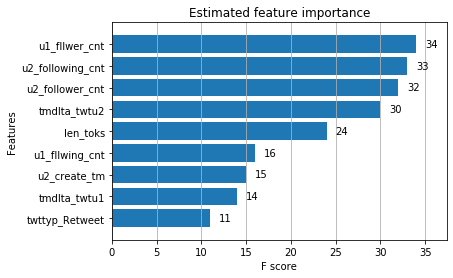

In [60]:
show_feat_importance(bst)

In [61]:
feat2importance=bst.get_fscore()
pd.DataFrame([feat2importance.keys(), feat2importance.values()]).T.sort_values(1, ascending=False).head(20)

,0,1
6,u1_fllwer_cnt,34
9,u2_following_cnt,33
1,u2_follower_cnt,32
18,tmdlta_twtu2,30
7,len_toks,24
13,u1_fllwing_cnt,16
17,u2_create_tm,15
26,tmdlta_twtu1,14
4,twttyp_Retweet,11
15,num_links,9


In [62]:
bst.save_model(f'{p_out}/bst_{PRFX}.model')


In [63]:
bst.load_model(f'{p_out}/bst_{PRFX}.model') 


In [64]:
prdtr = bst.predict(dtr)
prdvl = bst.predict(dvl)

In [65]:
tgt2auc_trn={}
tgt2rce_trn={}
tgt2auc_val={}
tgt2rce_val={}
for itgt, tgt in enumerate(tgts):
    print(tgt)
    prdtr_i, prdvl_i = (prd[:,itgt] for prd in (prdtr,prdvl))
    ytr_i, yvl_i = ((y==itgt).astype(int) for y in (ytr,yvl))
    scr_rocauc_trn = roc_auc_score(ytr_i, prdtr_i)
    scr_rocauc_val = roc_auc_score(yvl_i, prdvl_i)
    scr_auc_trn=compute_prauc(prdtr_i, ytr_i)
    scr_rce_trn=compute_rce(prdtr_i, ytr_i)
    scr_auc_val=compute_prauc(prdvl_i, yvl_i)
    scr_rce_val=compute_rce(prdvl_i, yvl_i)

    tgt2auc_trn[tgt]=scr_auc_trn
    tgt2rce_trn[tgt]=scr_rce_trn
    tgt2auc_val[tgt]=scr_auc_val
    tgt2rce_val[tgt]=scr_rce_val
    
    print('train rocauc:', f'{scr_rocauc_trn:.4f}', 'valid auc:', f'{scr_rocauc_val:.4f}', )
    print('train prauc:', f'{scr_auc_trn:.4f}', 'valid auc:', f'{scr_auc_val:.4f}', )
    print('train rce:', f'{scr_rce_trn:.4f}', 'valid rce:', f'{scr_rce_val:.4f}', )

Retweet
train rocauc: 0.6697 valid auc: 0.6675
train prauc: 0.2360 valid auc: 0.2359
train rce: -4.6250 valid rce: -4.2280
Reply
train rocauc: 0.7174 valid auc: 0.7171
train prauc: 0.0691 valid auc: 0.0699
train rce: -87.1074 valid rce: -85.9415
Like
train rocauc: 0.6745 valid auc: 0.6742
train prauc: 0.5631 valid auc: 0.5624
train rce: -6.7844 valid rce: -6.7528
RTwCmnt
train rocauc: 0.5525 valid auc: 0.5503
train prauc: 0.0087 valid auc: 0.0089
train rce: -344.3565 valid rce: -334.0850


In [22]:
lsttrn=[]
lstval=[]
for tgt in ['Retweet','Reply','Like','RTwCmnt',]:
    lsttrn+=[(f'PRAUC {tgt}',tgt2auc_trn[tgt]),
          (f'RCE {tgt}',tgt2rce_trn[tgt])]
    lstval+=[(f'PRAUC {tgt}',tgt2auc_val[tgt]),
          (f'RCE {tgt}',tgt2rce_val[tgt])]

dfscrtrn=pd.DataFrame(lsttrn)
dfscrtrn.columns=['metric','scr']
dfscrval=pd.DataFrame(lstval)
dfscrval.columns=['metric','scr']
dfscr = pd.merge(dfscrtrn, dfscrval, on='metric', suffixes=('trn','val'))
dfscr.T

,0,1,2,3,4,5,6,7
metric,PRAUC Retweet,RCE Retweet,PRAUC Reply,RCE Reply,PRAUC Like,RCE Like,PRAUC RTwCmnt,RCE RTwCmnt
scrtrn,0.295713,11.6979,0.126078,13.5504,0.628945,11.3893,0.0576701,9.76885
scrval,0.264104,9.73564,0.090286,10.2827,0.616244,10.5241,0.0161816,4.24093


# infer

In [23]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{valtmstmp}.tsv',
    sep='\x01', header=None, names=cols_val,)


CPU times: user 1min 42s, sys: 11.8 s, total: 1min 53s
Wall time: 3min 34s


In [24]:
%%time
dftst = prp_df(dftst)

CPU times: user 1min 55s, sys: 11.6 s, total: 2min 7s
Wall time: 2min 23s


In [25]:
Xtst=dftst[cols_feat].values

In [ ]:
dtst = xgb.DMatrix(Xtst, feature_names=cols_feat)
prdtst = bst.predict(dtst)

In [ ]:
tgt2prdtst={}
for itgt, tgt in enumerate(tgts):
    print(tgt)
    tgt2prdtst[tgt] = prdtst[:,itgt]
    

In [ ]:
dfsub_ids = dftst[['twtid','u2id',]]
tgt2dfsub = {}
for tgt,prdtst in tgt2prdtst.items():
    dfsub = dfsub_ids.copy()
    dfsub['scr'] = prdtst
    tgt2dfsub[tgt]=dfsub

In [ ]:
%%time
for tgt, dfsub in tgt2dfsub.items():
    print(dtnow(), tgt)
    dfsub.to_csv(f'{p_out}/{tgt}__{valtmstmp}__{PRFX}.csv',index=False,header=False)